In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

kaggle/Sample_Submission.xlsx
kaggle/Training_Dataset.xlsx
kaggle/Testing_Dateset.xlsx


In [3]:

# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm openpyxl -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import xgboost as xgb
import lightgbm as lgb

In [4]:

print("PURCHASE INTENT PREDICTION - DUAL OUTPUT PIPELINE")
print("=" * 60)
print("This pipeline creates two submission files:")
print("1. submission_probability.csv - Probability predictions (0-1)")
print("2. submission_binary.csv - Binary predictions (0 or 1)")
print("=" * 60)

PURCHASE INTENT PREDICTION - DUAL OUTPUT PIPELINE
This pipeline creates two submission files:
1. submission_probability.csv - Probability predictions (0-1)
2. submission_binary.csv - Binary predictions (0 or 1)


In [5]:
# Load data
print("\nStep 1: Loading datasets...")
train_df = pd.read_excel('kaggle/Training_Dataset.xlsx')
test_df = pd.read_excel('kaggle/Testing_Dateset.xlsx')
sample_submission = pd.read_excel('kaggle/sample_Submission.xlsx')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")


Step 1: Loading datasets...
Training data shape: (177086, 23)
Test data shape: (44272, 23)
Sample submission shape: (4, 2)


In [6]:
# Correct test IDs to continue from training data
test_df['ID'] = range(177087, 177087 + len(test_df))
print(f"Test IDs corrected: {test_df['ID'].min()} to {test_df['ID'].max()}")

Test IDs corrected: 177087 to 221358


In [7]:
# Extract and validate target variable
y = train_df['Result'].values.astype(int)
print(f"\nTarget distribution: Class 0={sum(y==0)}, Class 1={sum(y==1)}")
print(f"Class balance: {sum(y==1)/len(y)*100:.1f}% positive class")


Target distribution: Class 0=101421, Class 1=75665
Class balance: 42.7% positive class


In [8]:
# Feature engineering function
def engineer_features(df):
    df = df.copy()

    # Date features
    for col in ['Start Date', 'End Date']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    if 'Start Date' in df.columns and 'End Date' in df.columns:
        _extracted_from_engineer_features_10(df)


# TODO Rename this here and in `engineer_features`
def _extracted_from_engineer_features_10(df):
    df['Journey_Duration'] = (df['End Date'] - df['Start Date']).dt.days
    df['Journey_Duration'] = df['Journey_Duration'].fillna(0).clip(lower=0, upper=365)

    df['Start_Year'] = df['Start Date'].dt.year.fillna(2021)
    df['Start_Month'] = df['Start Date'].dt.month.fillna(6)
    df['Start_Quarter'] = df['Start Date'].dt.quarter.fillna(2)
    df['Start_DayOfWeek'] = df['Start Date'].dt.dayofweek.fillna(3)

    df['End_Year'] = df['End Date'].dt.year.fillna(2021)
    df['End_Month'] = df['End Date'].dt.month.fillna(6)
    df['End_Quarter'] = df['End Date'].dt.quarter.fillna(2)
    df['End_DayOfWeek'] = df['End Date'].dt.dayofweek.fillna(3)

    df = df.drop(['Start Date', 'End Date'], axis=1)


In [9]:
# Load data
print("\nStep 1: Loading datasets...")
train_df = pd.read_excel('kaggle/Training_Dataset.xlsx')
test_df = pd.read_excel('kaggle/Testing_Dateset.xlsx')
sample_submission = pd.read_excel('kaggle/Sample_Submission.xlsx')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

# Correct test IDs to continue from training data
test_df['ID'] = range(177087, 177087 + len(test_df))
print(f"Test IDs corrected: {test_df['ID'].min()} to {test_df['ID'].max()}")

# Extract and validate target variable
y = train_df['Result'].values.astype(int)
print(f"\nTarget distribution: Class 0={sum(y==0)}, Class 1={sum(y==1)}")
print(f"Class balance: {sum(y==1)/len(y)*100:.1f}% positive class")


Step 1: Loading datasets...
Training data shape: (177086, 23)
Test data shape: (44272, 23)
Sample submission shape: (4, 2)
Test IDs corrected: 177087 to 221358

Target distribution: Class 0=101421, Class 1=75665
Class balance: 42.7% positive class


In [10]:
# Feature engineering function
def engineer_features(df):
    df = df.copy()
    
    # Date features
    for col in ['Start Date', 'End Date']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    
    start_col = 'Start Date'
    end_col = 'End Date'
    if start_col in df.columns and end_col in df.columns:
        df['Journey_Duration'] = (df[end_col] - df[start_col]).dt.days
        df['Journey_Duration'] = df['Journey_Duration'].fillna(0).clip(lower=0, upper=365)
        
        df['Start_Year'] = df[start_col].dt.year.fillna(2021)
        df['Start_Month'] = df[start_col].dt.month.fillna(6)
        df['Start_Quarter'] = df[start_col].dt.quarter.fillna(2)
        df['Start_DayOfWeek'] = df[start_col].dt.dayofweek.fillna(3)
        
        df['End_Year'] = df[end_col].dt.year.fillna(2021)
        df['End_Month'] = df[end_col].dt.month.fillna(6)
        df['End_Quarter'] = df[end_col].dt.quarter.fillna(2)
        df['End_DayOfWeek'] = df[end_col].dt.dayofweek.fillna(3)
        
        df = df.drop([start_col, end_col], axis=1)
    
    # Numerical features
    if 'Price' in df.columns:
        price_median = df['Price'].median()
        df['Price'] = df['Price'].fillna(price_median)
        df['Price_Log'] = np.log1p(df['Price'].clip(lower=0))
        df['Price_Sqrt'] = np.sqrt(df['Price'].clip(lower=0))
    
    if 'Estimated Win Rate' in df.columns:
        df['Estimated Win Rate'] = df['Estimated Win Rate'].fillna(0.5)
        df['Win_Rate_Squared'] = df['Estimated Win Rate'] ** 2
        df['Win_Rate_High'] = (df['Estimated Win Rate'] > 0.75).astype(int)
        df['Win_Rate_Low'] = (df['Estimated Win Rate'] < 0.25).astype(int)
    
    if 'Unit Number' in df.columns:
        df['Unit Number'] = df['Unit Number'].fillna(0)
        df['Unit_Log'] = np.log1p(df['Unit Number'])
        df['Has_Units'] = (df['Unit Number'] > 0).astype(int)
        df['Multiple_Units'] = (df['Unit Number'] > 1).astype(int)
    
    # Customer segments
    segment_cols = [f'Customer Segment {i}' for i in range(1, 6)]
    if (existing_segments := [col for col in segment_cols if col in df.columns]):
        df['Active_Segments'] = df[existing_segments].notna().sum(axis=1)
    
    # Manager features
    if 'Manager' in df.columns:
        df['Has_Manager'] = df['Manager'].notna().astype(int)
    if 'Techincal Manager' in df.columns:
        df['Has_Tech_Manager'] = df['Techincal Manager'].notna().astype(int)
    
    return df

In [11]:
print("\nStep 2: Engineering features...")
train_featured = engineer_features(train_df)
test_featured = engineer_features(test_df)


Step 2: Engineering features...


In [12]:
exclude_cols = ['ID', 'Result', 'Customer ID']
feature_cols = [col for col in train_featured.columns if col not in exclude_cols]

X = train_featured[feature_cols].copy()
X_test = test_featured[feature_cols].copy()

In [13]:
# Align columns
common_cols = sorted(list(set(X.columns) & set(X_test.columns)))
X = X[common_cols]
X_test = X_test[common_cols]

print(f"Features selected: {len(common_cols)} common features")

# Encode categorical features
print("\nStep 3: Encoding categorical variables...")
categorical_cols = X.select_dtypes(include=['object']).columns
print(f"Categorical columns to encode: {len(categorical_cols)}")

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = X[col].fillna('missing').astype(str)
    X_test[col] = X_test[col].fillna('missing').astype(str)
    all_values = pd.concat([X[col], X_test[col]]).unique()
    le.fit(all_values)
    X[col] = le.transform(X[col])
    X_test[col] = le.transform(X_test[col])


Features selected: 38 common features

Step 3: Encoding categorical variables...
Categorical columns to encode: 15


In [14]:
 #Handle remaining missing values
for col in X.columns:
    if X[col].isnull().any():
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
        X_test[col] = X_test[col].fillna(median_val)

In [15]:
# Convert to arrays
X = X.values.astype(np.float32)
X_test = X_test.values.astype(np.float32)

print(f"Final shapes - Training: {X.shape}, Test: {X_test.shape}")

Final shapes - Training: (177086, 38), Test: (44272, 38)


In [16]:
# Model training
print("\nStep 4: Training models...")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=150, max_depth=12, min_samples_split=15,
        min_samples_leaf=8, max_features='sqrt',
        random_state=42, n_jobs=-1
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=150, max_depth=6, learning_rate=0.08,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, use_label_encoder=False, eval_metric='logloss'
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=150, max_depth=6, learning_rate=0.08,
        num_leaves=40, subsample=0.8, colsample_bytree=0.8,
        random_state=42, verbose=-1
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=150, max_depth=5, learning_rate=0.08,
        subsample=0.8, max_features='sqrt',
        random_state=42
    )
}

validation_scores = {}
test_probabilities = {}
test_binary = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
        # Validation performance
    val_prob = model.predict_proba(X_val)[:, 1]
    val_binary = model.predict(X_val)
    
    auc = roc_auc_score(y_val, val_prob)
    acc = accuracy_score(y_val, val_binary)
    validation_scores[name] = auc
    
    # Test predictions - both probability and binary
    test_prob = model.predict_proba(X_test)[:, 1]
    test_bin = model.predict(X_test)
    
    test_probabilities[name] = test_prob
    test_binary[name] = test_bin
    
    print(f"  Validation AUC: {auc:.4f}")
    print(f"  Validation Accuracy: {acc:.4f}")



Step 4: Training models...

Training RandomForest...
  Validation AUC: 0.9978
  Validation Accuracy: 0.9909

Training XGBoost...
  Validation AUC: 0.9979
  Validation Accuracy: 0.9916

Training LightGBM...
  Validation AUC: 0.9979
  Validation Accuracy: 0.9914

Training GradientBoosting...
  Validation AUC: 0.9979
  Validation Accuracy: 0.9912


In [17]:

# Create ensembles
print("\nStep 5: Creating ensemble predictions...")


Step 5: Creating ensemble predictions...


In [18]:
# Calculate weights based on AUC scores
total_score = sum(validation_scores.values())
weights = {name: score/total_score for name, score in validation_scores.items()}

print("Model weights based on AUC:")
for name, weight in sorted(weights.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name}: {weight:.3f}")


Model weights based on AUC:
  XGBoost: 0.250
  LightGBM: 0.250
  GradientBoosting: 0.250
  RandomForest: 0.250


In [19]:
# Weighted ensemble for probabilities
ensemble_prob = np.zeros(len(X_test))
for name, weight in weights.items():
    ensemble_prob += test_probabilities[name] * weight


In [20]:
# Majority voting for binary predictions
ensemble_binary_votes = np.array(list(test_binary.values()))
ensemble_binary = (ensemble_binary_votes.sum(axis=0) >= len(models)/2).astype(int)


In [21]:
# Retrain on full data for final predictions
print("\nStep 6: Retraining on full dataset...")
final_probabilities = []
final_binary_predictions = []

for name, model in models.items():
    print(f"Retraining {name}...")
    model.fit(X, y)
    
    prob = model.predict_proba(X_test)[:, 1]
    binary = model.predict(X_test)
    
    final_probabilities.append(prob)
    final_binary_predictions.append(binary)


Step 6: Retraining on full dataset...
Retraining RandomForest...
Retraining XGBoost...
Retraining LightGBM...
Retraining GradientBoosting...


In [22]:

# Final ensembles
final_ensemble_prob = np.mean(final_probabilities, axis=0)
final_ensemble_binary = (np.array(final_binary_predictions).sum(axis=0) >= len(models)/2).astype(int)
print("\nStep 7: Creating submission files...")



Step 7: Creating submission files...


In [23]:
# Submission 1: Probability predictions (for ROC AUC evaluation)
submission_probability = pd.DataFrame({
    'ID': test_featured['ID'].values,
    'TARGET': final_ensemble_prob
})
submission_probability['TARGET'] = submission_probability['TARGET'].clip(0.0001, 0.9999)

In [24]:
# Submission 2: Binary predictions
submission_binary = pd.DataFrame({
    'ID': test_featured['ID'].values,
    'TARGET': final_ensemble_binary
})

# Save both files
submission_probability.to_csv('submission_probability.csv', index=False)
submission_binary.to_csv('submission_binary.csv', index=False)

In [25]:
# Display statistics
print("\n" + "=" * 60)
print("SUBMISSION FILE 1: PROBABILITY PREDICTIONS")
print("File name: submission_probability.csv")
print(f"Shape: {submission_probability.shape}")
print(f"TARGET range: [{submission_probability['TARGET'].min():.4f}, {submission_probability['TARGET'].max():.4f}]")
print(f"TARGET mean: {submission_probability['TARGET'].mean():.4f}")
print(f"TARGET std: {submission_probability['TARGET'].std():.4f}")
print("\nFirst 5 rows:")
print(submission_probability.head())

print("\n" + "=" * 60)
print("SUBMISSION FILE 2: BINARY PREDICTIONS")
print("File name: submission_binary.csv")
print(f"Shape: {submission_binary.shape}")
print(f"Class distribution: 0={sum(submission_binary['TARGET']==0)}, 1={sum(submission_binary['TARGET']==1)}")
print(f"Positive class percentage: {sum(submission_binary['TARGET']==1)/len(submission_binary)*100:.1f}%")
print("\nFirst 5 rows:")
print(submission_binary.head())



SUBMISSION FILE 1: PROBABILITY PREDICTIONS
File name: submission_probability.csv
Shape: (44272, 2)
TARGET range: [0.0001, 0.9973]
TARGET mean: 0.3056
TARGET std: 0.4542

First 5 rows:
       ID    TARGET
0  177087  0.990085
1  177088  0.021236
2  177089  0.000282
3  177090  0.002150
4  177091  0.000312

SUBMISSION FILE 2: BINARY PREDICTIONS
File name: submission_binary.csv
Shape: (44272, 2)
Class distribution: 0=30579, 1=13693
Positive class percentage: 30.9%

First 5 rows:
       ID  TARGET
0  177087       1
1  177088       0
2  177089       0
3  177090       0
4  177091       0


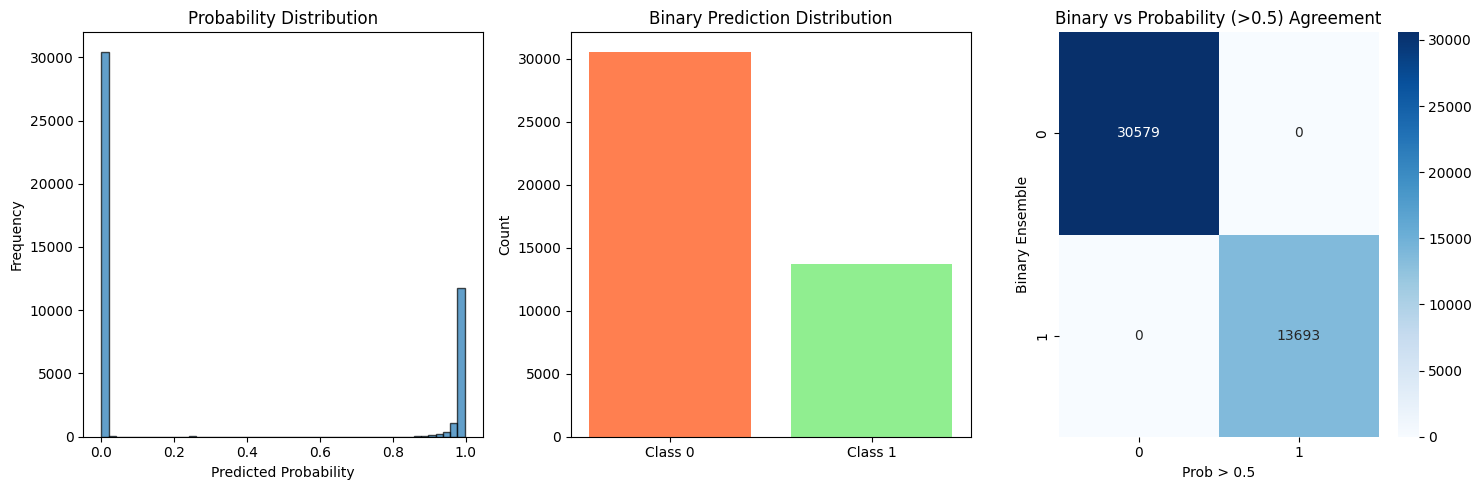


PIPELINE COMPLETED SUCCESSFULLY

Two submission files created:
1. submission_probability.csv - Use this for ROC AUC evaluation
2. submission_binary.csv - Binary classification output

The competition requires probability predictions for ROC AUC scoring.


In [26]:
# Comparison visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(submission_probability['TARGET'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Probability Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.bar(['Class 0', 'Class 1'], 
        [sum(submission_binary['TARGET']==0), sum(submission_binary['TARGET']==1)],
        color=['coral', 'lightgreen'])
plt.title('Binary Prediction Distribution')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
threshold = 0.5
binary_from_prob = (submission_probability['TARGET'] > threshold).astype(int)
confusion = pd.crosstab(submission_binary['TARGET'], binary_from_prob, 
                        rownames=['Binary Ensemble'], colnames=['Prob > 0.5'])
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Binary vs Probability (>0.5) Agreement')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("PIPELINE COMPLETED SUCCESSFULLY")
print("\nTwo submission files created:")
print("1. submission_probability.csv - Use this for ROC AUC evaluation")
print("2. submission_binary.csv - Binary classification output")
print("\nThe competition requires probability predictions for ROC AUC scoring.")
print("=" * 60)